In [57]:
new_train_data = pd.read_parquet('processed_data.parquet')
new_val_data = pd.read_parquet('val_data.parquet')
example = pd.read_csv('dataset_2nd/private_2_template_v2.csv')

In [61]:
cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour']

columns_to_drop = ['label', 'txkey', 'chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm', 'first_use_date',
                   'last_use_date', 'days_active']

# 從數據框中刪除指定的列
X = new_train_data.drop(columns=columns_to_drop)
y = new_train_data['label']


In [62]:
for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.35, 
    random_state=40, 
    stratify=y
)

train_pool = Pool(X_train, y_train,cat_features=cat_features)
test_pool = Pool(X_test, y_test,cat_features=cat_features)

In [63]:
for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.35, 
    random_state=40, 
    stratify=y
)

train_pool = Pool(X_train, y_train,cat_features=cat_features)
test_pool = Pool(X_test, y_test,cat_features=cat_features)

In [70]:
"""
註記：若電腦為MAC系列，則須無法使用 task_type='GPU'，可將其註解並且開啟subsample，接受另外兩個參數再進行訓練，超參數皆無須調整

"""
catboost_model = CatBoostClassifier(
    iterations=5000,  
    learning_rate=0.0765,
    depth=7,
    loss_function='Logloss',
    eval_metric='F1',  
    early_stopping_rounds=500,
    random_seed=42,
    verbose=100,
    l2_leaf_reg=3,
    leaf_estimation_iterations=10,
    colsample_bylevel=0.8,
    subsample=0.85,
    max_ctr_complexity=10,
#     task_type='GPU',
    scale_pos_weight = 9.35, # 9.45
    random_strength=3,
    grow_policy='Lossguide'
)

catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

0:	learn: 0.8481921	test: 0.8500659	best: 0.8500659 (0)	total: 1.61s	remaining: 2h 14m 20s
100:	learn: 0.9164226	test: 0.9157306	best: 0.9158556 (99)	total: 2m 23s	remaining: 1h 55m 36s
200:	learn: 0.9302458	test: 0.9255256	best: 0.9255256 (200)	total: 4m 51s	remaining: 1h 56m 1s
300:	learn: 0.9418728	test: 0.9327726	best: 0.9327726 (300)	total: 7m 5s	remaining: 1h 50m 38s
400:	learn: 0.9498999	test: 0.9384845	best: 0.9384845 (400)	total: 9m 7s	remaining: 1h 44m 43s
500:	learn: 0.9569375	test: 0.9438146	best: 0.9438146 (500)	total: 11m 5s	remaining: 1h 39m 35s
600:	learn: 0.9622362	test: 0.9464727	best: 0.9464767 (599)	total: 13m 1s	remaining: 1h 35m 18s
700:	learn: 0.9661670	test: 0.9483984	best: 0.9485467 (695)	total: 14m 50s	remaining: 1h 30m 58s
800:	learn: 0.9696428	test: 0.9501022	best: 0.9502713 (789)	total: 16m 39s	remaining: 1h 27m 19s
900:	learn: 0.9727747	test: 0.9517177	best: 0.9517177 (900)	total: 18m 28s	remaining: 1h 24m 3s
1000:	learn: 0.9755051	test: 0.9531337	best: 0.

In [73]:
# 預測概率
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# 計算精確度和召回率以及閾值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 計算 F1 分數
f1_scores = 2 * recall * precision / (recall + precision)
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]

# 使用最佳閾值進行預測
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

# 計算調整後的精確度和召回率
adjusted_precision = precision_score(y_test, y_pred_custom)
adjusted_recall = recall_score(y_test, y_pred_custom)
adjusted_f1 = f1_score(y_test, y_pred_custom)

print(f"Best Threshold: {best_threshold}")
print(f"Adjusted Precision: {adjusted_precision}")
print(f"Adjusted Recall: {adjusted_recall}")

Best Threshold: 0.7577747057300599
Adjusted Precision: 0.9419632194888942
Adjusted Recall: 0.9009365719942131


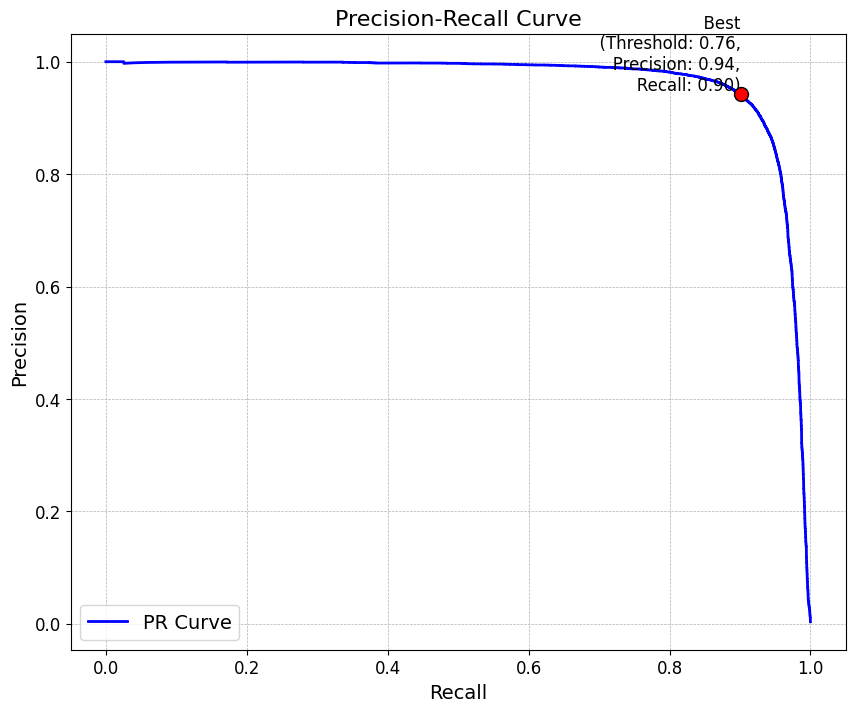

In [74]:
import matplotlib.pyplot as plt

# 假設 y_test 和 y_pred_proba 已經定義好
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 計算 F1 分數
f1_scores = 2 * recall * precision / (recall + precision)

# 找到最大 F1 分數對應的閾值
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
best_precision = precision[max_f1_index]
best_recall = recall[max_f1_index]

# 繪製 PR 曲線
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label='PR Curve', color='blue', linewidth=2)
plt.scatter(best_recall, best_precision, color='red', s=100, edgecolor='black', zorder=5)
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 標記最佳閾值和對應的精確度、召回率
plt.text(best_recall, best_precision, f'  Best\n  (Threshold: {best_threshold:.2f},\n   Precision: {best_precision:.2f},\n   Recall: {best_recall:.2f})', 
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.legend(fontsize=14)
plt.show()



In [76]:
new_val_data = new_val_data.set_index('txkey')
columns_to_drop = ['chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm', 'first_use_date',
                   'last_use_date', 'days_active']

cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour']

X = new_val_data.drop(columns=columns_to_drop)

for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
test_pool = Pool(X, cat_features=cat_features)


In [77]:
y_pred_proba = catboost_model.predict_proba(test_pool)[:, 1]
y_pred_custom = (y_pred_proba > best_threshold).astype(int)
new_val_data['pred'] = y_pred_custom
new_val_data = new_val_data.reset_index()
output_df = new_val_data[['txkey', 'pred']].set_index('txkey')
example = example.drop_duplicates(subset='txkey')

df2_sorted = example[['txkey']].merge(output_df, on='txkey', how='left')
df2_sorted = df2_sorted.set_index('txkey')
df2_sorted

,pred
txkey,
2dc3cfff76e54b508aec3a1ab7d3f3b9770d670c9cb9888f45ab96039212d609,0
5e4e0386a88cdf7847631e80fb129bbbf942a8ab68390bed581bf25738547e2f,0
ba2ec4f84fa996e4dbcb42984451b217fe2e9cd0b7d3da363c76df34b59ee6e0,0
a6f137a7444829310471ff9dd051addc349920ae07c5bbbd86ee4a58c05c8d8f,0
b4b3f47913e3142ca7cc54ab5d98fafc00174ad1c632069b3babc30f7ad9daad,0
...,...
f192c75180efd46e8746c9926d48f89b4f9bd730974d675d68f6bedc82ecdc06,0
79a032788e6f1c684a8c1ac514f8bd3c9fc9949869860492e9e5bea9c623db83,0
03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff494c8690ce18af3378,0


In [79]:
df2_sorted['pred'].value_counts()

pred
0    801733
1      3988
Name: count, dtype: int64

In [82]:
df2_sorted.to_csv('data2/TEAM_4614.csv')